In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor

# pour afficher dynamiquement dans le notebook
from IPython.display import clear_output
from IPython.display import display, Math, Markdown
import time

# pour le clustering : 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import preprocessing # normalisation des données

import statsmodels.api as sm
from statsmodels.formula.api import ols

import json # pour le stockage de dict

import iteround

## Sommaire <a id="sommaire">

- [Préparation des données](#prep_donnees)
    - [distribution des revenus](#prep-donnees-dist-reve)
    - [indice de Gini](#prep-donnees-gini)
    - [population](#prep-donnees-population)
    - [Coefficient d'élasticité](#prep-donnees-elasticite)
- [Mission 1](#mission-1)
- [Mission 2](#mission-2)
- [Mission 3](#mission-3) : [étape 1](#m3-step1), [2](#m3-step2), [3](#m3-step3), [4](#m3-step4), [5](#m3-step5), [6](#m3-step6), [7](#m3-step7), [8](#m3-step8), [9](#m3-step9), [10](#m3-step10), [11](#m3-step11)
- [Mission 4](#mission-4)
    - [ANOVA](#m4-anova)
    - [Régressions linéaires](#m4-reg_lin)
        - [Régression linéaire 1](#reg1) : 
            - [Version sans logarithme](#reg1-lin)
            - [Version avec logarithme](#reg1-log)
            - [Question 1](#reg1_q1)
        - [Régression linéaire 2](#reg2) :
            - [Version sans logarithme](#reg2-lin)
            - [Version avec logarithme](#reg2-log)
            - [Question 1](#reg2_q1)
            - [Question 2](#reg2_q2)
- [Prédiction finale](#prediction-finale)

## Préparation des données <a id="prep_donnees" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

Pour chaque pays du monde, nous manipulerons :
- La distribution des revenus
- L'indice de Gini
- La population
- Le coefficient d'élasticité

### Pays de références

C'est la liste des codes iso des pays que nous considérons comme référence pour ce projet

In [135]:
pays_ref = pd.read_csv('donnees/pays_ref.csv')
pays_ref.set_index(pays_ref['iso3'], inplace=True)

### Distribution des revenus <a id="prep-donnees-dist-reve" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

In [136]:
dist_revenus = pd.read_csv('donnees/world_income_distribution_04-11.csv', decimal=",")

#### GDP PPP manquants

Les valeurs du gdp ppp sont manquantes pour les pays Kosovo (XKX) et la Paléstine (PSE). On va les ajouter manuellement.

Le gdp ppp des Fiji est de 4 millions, ce qui semble abérant. On va le remplacer.

Sources :
- <a href="https://www.indexmundi.com/fiji/gdp_per_capita_(ppp\).html"> GDP PPP des Fijis en 2008 </a>
- [GDP PPP du Kosvo en 2008](https://www.ceicdata.com/en/indicator/kosovo/gdp-per-capita)
- [GDP PPP de la Paléstine en 2009](https://www.theglobaleconomy.com/Palestine/GDP_per_capita_PPP/)

In [4]:
dist_revenus.loc[dist_revenus['country'] == 'FJI', 'gdpppp'] = 6848.6
dist_revenus.loc[dist_revenus['country'] == 'XKX', 'gdpppp'] = 3254.9
dist_revenus.loc[dist_revenus['country'] == 'PSE', 'gdpppp'] = 4179.1

#### quantiles manquants

In [5]:
pays_nb_quantiles = dist_revenus[['country', 'quantile']].groupby('country').count()
pays_nb_quantiles[pays_nb_quantiles['quantile'] != 100]

,quantile
country,
LTU,99


In [6]:
ltu_quantiles = dist_revenus.loc[dist_revenus['country'] == 'LTU', 'quantile'].values

In [7]:
for i in range(1,101):
    if i not in ltu_quantiles: print(i)

41


In [8]:
dist_revenus.loc[(dist_revenus['country'] == 'LTU') & (dist_revenus['quantile'].isin([40,42]))]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6239,LTU,2008,40,100,4868.4507,17571.0
6240,LTU,2008,42,100,4895.8306,17571.0


**Il manque uniquement le quantile 41 de la Lithuanie**

On va le deviner en faisant la moyenne du quantile 40 et 42

In [9]:
q40_income = dist_revenus.loc[
        (dist_revenus['country'] == 'LTU') & 
        (dist_revenus['quantile'] == 40), 'income'
    ].values[0]

q42_income = dist_revenus.loc[
        (dist_revenus['country'] == 'LTU') & 
        (dist_revenus['quantile'] == 42), 'income'
    ].values[0]

In [10]:
dist_revenus.loc['6239a'] = ['LTU', 2008, 41, 100, (q40_income + q42_income) / 2, 17571.0]

#### Liste de GDP PPP
On va crééer un dataframe séparé qui ne contient que les GDP PPP

In [11]:
gdp_ppp = dist_revenus[['country', 'gdpppp']].drop_duplicates()
gdp_ppp.set_index('country', inplace=True)

In [12]:
gdp_ppp.head(1)

,gdpppp
country,
ALB,7297.0


### Indice de Gini <a id="prep-donnees-gini" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

In [13]:
indice_gini = pd.read_csv('donnees/indice_gini_60-17.csv')
indice_gini = indice_gini.set_index('Country Code')

In [14]:
# on ne garde que les annees
indice_gini = indice_gini[[ str(x) for x in range(1960, 2017) ]]

In [15]:
# suppression des lignes avec que des valeurs nulles
indice_gini = indice_gini.dropna(how='all')

# suppression des colonnes avec que des valeurs nulles
indice_gini = indice_gini.dropna(axis=1, how='all')

#### Pays manquants

In [16]:
m = ~np.isin(pays_ref['iso3'].values, indice_gini.index.values)
pays_ref.loc[m, 'iso3']

iso3
POL    POL
SRB    SRB
KHM    KHM
TWN    TWN
PHL    PHL
Name: iso3, dtype: object

Certains pays de références (`pays_ref`) n'ont pas d'indice de Gini. On va les ajouter manuellement

Sources : 
- [Pologne](http://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?codeTheme=2&codeStat=PMQUANDL.GINI.V1&codePays=POL&optionsPeriodes=Aucune&codeTheme2=2&codeStat2=x&codePays2=POL&optionsDetPeriodes=avecNomP&langue=fr)
- [Serbie](https://tradingeconomics.com/serbia/gini-index-wb-data.html)
- [Cambodge](http://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?codeTheme=2&codeStat=PMQUANDL.GINI.V1&codePays=KHM&optionsPeriodes=Aucune&codeTheme2=2&codeStat2=x&codePays2=POL&optionsDetPeriodes=avecNomP&langue=fr)
- [Taiwan](https://www.researchgate.net/figure/Gini-Coefficients-in-Taiwan-1968-2010_fig3_311448696)
- [Philippines](http://perspective.usherbrooke.ca/bilan/servlet/BMTendanceStatPays?codeTheme=2&codeStat=PMQUANDL.GINI.V1&codePays=PHL&optionsPeriodes=Aucune&codeTheme2=2&codeStat2=x&codePays2=POL&optionsDetPeriodes=avecNomP&langue=fr)

In [17]:
indice_gini.loc['POL'] = np.nan
gini_pol = {'1992':26.70, '2005':35.86, '2015':31.82}
for annee in gini_pol:
    indice_gini.loc['POL', annee] = gini_pol[annee]

In [18]:
indice_gini.loc['SRB'] = np.nan
gini_srb = {'1992':43.82, '2003':44.04, '2012':43.04}
for annee in gini_srb:
     indice_gini.loc['SRB', annee] = gini_srb[annee]

In [19]:
indice_gini.loc['KHM'] = np.nan
gini_khm = {'1994':38.15, '2004':35.46, '2012':30.76}
for annee in gini_khm:
     indice_gini.loc['KHM', annee] = gini_khm[annee]

In [20]:
indice_gini.loc['TWN'] = np.nan
gini_twn = {'1995':31.8, '2005':34, '2010':34.1}
for annee in gini_twn:
     indice_gini.loc['TWN', annee] = gini_twn[annee]

In [21]:
indice_gini.loc['PHL'] = np.nan
gini_phl = {'1994':38.52, '2003':44.04, '2012':43.04}
for annee in gini_phl:
     indice_gini.loc['PHL', annee] = gini_phl[annee]

#### Indice Gini de référence
On va déterminer un indice de Gini unique de référence pour chaque pays.

Pour ce faire, on va calculer, pour chaque pays, **la moyenne de ces indices de Gini** sur la plus petite période qui contient au moins 1 indice de Gini par pays.

In [22]:
%time

# --- on détermine la plus petite période qui contient au moins 1 indice de Gini par pays ---

nb_pays_sans_ginis = lambda annees: (indice_gini.loc[:,annees].notna().sum(axis=1) == 0).sum()

# on commence avec une valeur abérante pour forcer l'initialisation avec la 1ere solution trouvée
plus_petit_intervalle_taille = 1000 
plus_petit_intervalle = None
# on enumere tout les intervalles d'années possibles sur la période 1979 - 2016
for annee_d in range(1979,2017):
    for annee_f in range(annee_d+1, 2017):
        annees = [str(x) for x in range(annee_d, annee_f)]
        # si on trouve un intervalle meilleur, on le garde
        if nb_pays_sans_ginis(annees) == 0 and len(annees) < plus_petit_intervalle_taille:
            plus_petit_intervalle_taille = len(annees)
            plus_petit_intervalle = annees

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


--> On trouve comme solution l'intervalle d'année 1992 - 2015

In [23]:
# On stocke la moyenne de cette intervalle pour chaque pays
indice_gini_ref = pd.DataFrame(indice_gini[plus_petit_intervalle].sum(axis=1) / indice_gini[plus_petit_intervalle].notna().sum(axis=1),
                               columns=['gini_ref'])

### Population <a id="prep-donnees-population" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

In [24]:
population = pd.read_csv('donnees/population_60-17.csv')
population = population.set_index('Country Code')

In [25]:
# on projette sur les annees
population = population[[ str(x) for x in range(1960, 2017) ]]

In [26]:
# suppression des lignes avec que des valeurs nulles
population = population.dropna(how='all')

# suppression des colonnes avec que des valeurs nulles
population = population.dropna(axis=1, how='all')

#### Population de référence

On prend 2011 comme année de référence, car c'est l'année la plus récente qui contient la population de tout les pays.

In [27]:
population_ref = population[['2011']]
population_ref.columns = ['population']

In [28]:
population_ref.head(2)

,population
Country Code,
ABW,102053.0
AFG,29708599.0


### Coefficient d'élasticitité <a id="prep-donnees-elasticite" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

On va appliquer à chaque pays son coefficient de région (qui est imprécis).

Puis, on appliquera aux pays connus leur coefficient de pays (plus précis).

In [29]:
# ouverture des coefficients de région / pays
elasticite_pays = pd.read_csv('donnees/elasticite_pays.csv')
elasticite_pays = elasticite_pays[['iso3', 'IGEincome']].drop_duplicates().dropna()

elasticite_region = pd.read_csv('donnees/elasticite_regions.csv', decimal=',')

In [30]:
elasticite_pays.shape

(75, 2)

In [31]:
# on applique a chaque pays le coefficient d'élasticité de sa région
coef_elasticite = pays_ref.merge(elasticite_region, how='left', on='region')

# puis, pour chaque pays pour lequel on a un coefficient plus précis
# on l'utilise pour écraser le coefficient de la région
for row in elasticite_pays.iterrows():
    iso = row[1][0]
    elasticite = row[1][1]
    
    if iso in coef_elasticite.iso3.values:
        coef_elasticite.loc[coef_elasticite.iso3 == iso, 'elasticite'] = elasticite

In [32]:
# on nettoie légèrement le DataFrame
coef_elasticite = coef_elasticite[['iso3', 'elasticite']]
coef_elasticite.set_index('iso3', inplace=True)

## Mission 1 <a id="mission-1" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

#### Resumé des données

<div class="panel panel-info">
  <div class="panel-heading"> 
    Résumé des données
  </div>
  <div class="panel-body">
    Année(s) des données utilisées
  </div>
</div>

In [33]:
dist_revenus_annees = np.sort(dist_revenus['year_survey'].unique())
indice_gini_annees = indice_gini.columns.values
population_annees = population.columns.values

In [34]:
print('Distribution des revenus : ')
for annee in dist_revenus_annees:
    print(annee, end=', ')

print('\n\nIndice de Gini : ')
for annee in indice_gini_annees:
    print(annee, end=', ')

print('\n\nPopulation :')
for annee in population_annees:
    print(annee, end=', ')

Distribution des revenus : 
2004, 2006, 2007, 2008, 2009, 2010, 2011, 

Indice de Gini : 
1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 

Population :
1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 

<div class="panel panel-info">
  <div class="panel-heading"> 
    Résumé des données
  </div>
  <div class="panel-body">
    Nombre de pays présents
  </div>
</div>

In [35]:
# on stocke la liste des pays présents dans les 3 dataframes
dist_revenus_pays = dist_revenus.country.unique()
indice_gini_pays = indice_gini.index.values
population_pays = population.index.values

In [36]:
print(f"""
Distribution des revenus  { len(dist_revenus_pays) } pays
Indice de Gini            { len(indice_gini_pays) } pays
Population                { len(population_pays) } pays et régions
""")


Distribution des revenus  116 pays
Indice de Gini            166 pays
Population                263 pays et régions



<div class="panel panel-info">
  <div class="panel-heading"> 
    Résumé des données
  </div>
  <div class="panel-body">
    Population couverte par l'analyse (en termes de pourcentage de la population mondiale)
  </div>
</div>

On considère seulement les pays qui ont au moins :
- 1 indice de Gini
- 1 distribution de revenus

In [37]:
# On ne garde que les pays qui sont dans dist_revenus_pays ET indice_gini_pays
pays = np.intersect1d(dist_revenus_pays, indice_gini_pays)

In [38]:
# Sont-ils tous présents dans population ?
np.isin(pays, population.index).any()

True

In [39]:
# Calcul de population totale des ces pays
pop_couverte_11 = population.loc[pays, '2011'].sum()

# et recuperation de la population mondiale
pop_monde_11 = population_ref.loc['WLD'].values[0]

/home/charlie/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [40]:
print(f"{pop_couverte_11 / pop_monde_11 * 100:.0f}% de la population est couverte")

91% de la population est couverte


<div class="panel panel-info">
  <div class="panel-heading"> 
    Résumé des données
  </div>
  <div class="panel-body">
    Quelle est le type de quantile de la World Income Distribution ?
  </div>
</div>

In [41]:
# Quelles sont les quantiles présents ?
dist_revenus.nb_quantiles.unique()

array([100])

Ce sont des centiles

<div class="panel panel-info">
  <div class="panel-heading"> 
    Résumé des données
  </div>
  <div class="panel-body">
    Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?
  </div>
</div>

Utiliser des centiles semblent pratique pour représenter la courbe de lorenz de manière compressée.
Cette courbe permet de bien observer les inégalités au sein d'un pays.
De plus, on peux facilement comparer deux pays dont la population serait différente.

Text(0,0.5,'revenus en $')

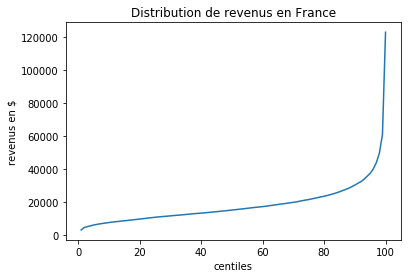

In [42]:
df = dist_revenus.loc[dist_revenus.country == 'FRA', ['income', 'quantile']]
plt.plot(df['quantile'], df['income'])
plt.title('Distribution de revenus en France')
plt.xlabel('centiles')
plt.ylabel('revenus en $')

<div class="panel panel-info">
  <div class="panel-heading"> 
    Résumé des données
  </div>
  <div class="panel-body">
    Qu'est ce que que *$PPP* ?
  </div>
</div>

**Purchasing power parity**, **Parité Pouvoir d'Achat en Français**, permet de comparer le pouvoir d'achat au sein de différents pays. C'est une façon de normaliser le pouvoir d'achat de chaque pays (exprimé en PIB / hab / an) en le convertissant en une monnaie de référence.

In [43]:
gdp_ppp.head(2)

,gdpppp
country,
ALB,7297.0
ARG,13220.0


## Mission 2 <a id="mission-2" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

<div class="panel panel-info">
  <div class="panel-heading"> 
    Ennoncé
  </div>
  <div class="panel-body">
    Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
  </div>
</div>

#### Sélection des pays

On va utiliser une méthode de clustering pour sélectionner automatiquement des pays qui sont différents entre eux.

##### Compilation des informations sur les pays

On créé un DataFrame qui qui contient pour chaque pays les informations suivantes :
- code iso3
- indice de gini de référence
- GDP PPP

In [44]:
# on merge l'indice de gini et la gdp ppp
pays_info = indice_gini_ref.merge(gdp_ppp, left_index=True, right_index=True)

##### Sélection de 5-10 pays

On va faire un clustering en 5 à 10 groupes pour rassembler les pays proches (et séparer les pays qui sont différents). on ne gardera que le pays moyen de chaque groupe.


In [45]:
nb_cluster = 5

# normalisation des donnees
pays_info_norm = preprocessing.scale(pays_info)
# Clustering avec la méthode des kmeans
km = KMeans(n_clusters = nb_cluster).fit(pays_info_norm)
# on determine les pays qui sont les plus proches des centroides des clusters
i_pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, pays_info_norm)

Ressource :
- [récuperer les points proches des centroides](https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn)
- [normalisation des données](https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/)

In [46]:
pays_representatifs_cluster = pays_info.iloc[i_pays_plus_proches].sort_values('gdpppp', ascending=False)
pays_representatifs_cluster

,gini_ref,gdpppp
AUT,30.269231,36193.0
KOR,31.900000,19162.0
ECU,50.629412,7560.0
ARM,32.156250,5611.0
MAR,40.075000,3973.0


In [47]:
codes_pays_representatifs = pays_representatifs_cluster.index.values
# pays = ['FRA', 'VNM', 'GHA', 'CZE']

<div class="panel panel-info">
  <div class="panel-heading"> 
    Ennoncé
  </div>
  <div class="panel-body">
   Représentez la courbe de Lorenz de chacun des pays choisis.
  </div>
</div>

#### Affichage des courbes de Lorenz

Text(0,0.5,'GDP PPP en $ (log)')

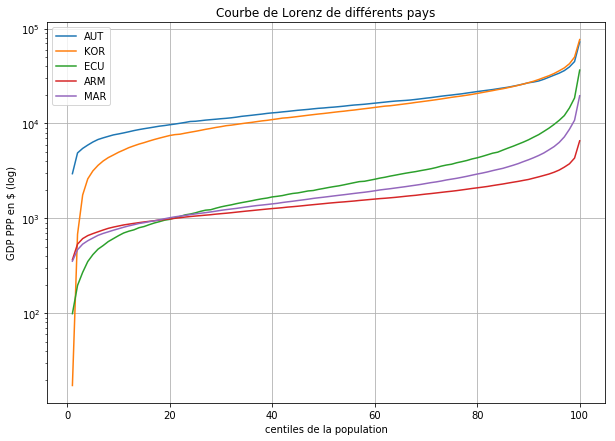

In [48]:
# initialisation de la figure
fig = plt.figure(figsize=(10,7))
ax = plt.gca()

for code_pays in codes_pays_representatifs:
        ax.plot(
            range(1,101), 
            dist_revenus.loc[dist_revenus.country == code_pays, 'income'],
            label=code_pays)
    
# on met l'axe y a l'échelle logarithmique
ax.set_yscale('log')

# on ajoute la légende et la grille
plt.legend(loc='upper left')
plt.grid(True)

# on ajoute des titres
plt.title('Courbe de Lorenz de différents pays')
plt.xlabel('centiles de la population')
plt.ylabel('GDP PPP en $ (log)')


<div class="panel panel-info">
  <div class="panel-heading"> 
    Ennoncé
  </div>
  <div class="panel-body">
   Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
  </div>
</div>

In [49]:
pays_ref.head(10)

,iso3,region
iso3,,
CAN,CAN,nordic_european_countries_and_canada
DNK,DNK,nordic_european_countries_and_canada
FIN,FIN,nordic_european_countries_and_canada
ISL,ISL,nordic_european_countries_and_canada
NOR,NOR,nordic_european_countries_and_canada
SWE,SWE,nordic_european_countries_and_canada
ALB,ALB,europe_except_nordic_countries
AUT,AUT,europe_except_nordic_countries
BEL,BEL,europe_except_nordic_countries


Text(0,0.5,'Indice de Gini')

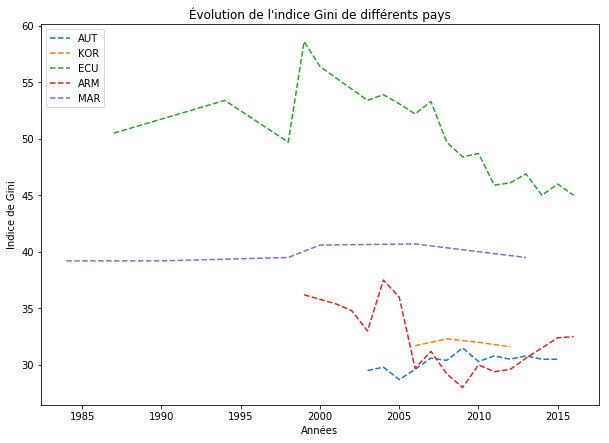

In [50]:
# taille de la figure
plt.figure(figsize=(10,7))

for code_pays in codes_pays_representatifs:
    # pour chaque pays, on détermine les gini et les années correspondantes
    s = indice_gini.loc[code_pays, :].dropna()
    values = s.values
    years = s.index.values.astype(np.int)
    # on plot une nouvelle ligne 
    plt.plot(years, values, '--', label=code_pays)

# ajout de la légende et des titres
plt.legend(loc='upper left')
plt.title("Évolution de l'indice Gini de différents pays")
plt.xlabel('Années')
plt.ylabel('Indice de Gini')

<div class="panel panel-info">
  <div class="panel-heading"> 
    Ennoncé
  </div>
  <div class="panel-body">
   Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?
  </div>
</div>

In [51]:
# ajout d'une colonne qui donne le rang de chaque pays
# en fonction de son indice de gini de référence
indice_gini_rank = indice_gini_ref.copy()
indice_gini_rank['rank'] = indice_gini_rank['gini_ref'].rank(ascending=True)

Les 5 pays avec le plus fort indice de Gini :

In [52]:
indice_gini_rank[indice_gini_rank['rank'] >= len(indice_gini_rank)-4].sort_values('rank', ascending=False)

,gini_ref,rank
Country Code,,
BWA,62.000000,166.0
ZAF,61.714286,165.0
NAM,61.133333,164.0
BLZ,57.733333,163.0
SUR,57.600000,162.0


Les 5 pays avec le plus faible indice de Gini :

In [53]:
indice_gini_rank[indice_gini_rank['rank'] <= 5].sort_values('rank')

,gini_ref,rank
Country Code,,
AZE,23.366667,1.0
SVN,25.276923,2.0
CZE,26.385714,3.0
SVK,26.653846,4.0
DNK,26.700000,5.0


In [54]:
fr_gini = indice_gini_rank.loc['FRA', 'gini_ref']
fr_gini_rank = indice_gini_rank.loc['FRA', 'rank']

In [55]:
print(f"""
La France a un indice Gini de {fr_gini:.2f} (moyenne sur les années 2003-2015).
Parmis les {len(indice_gini_rank)} pays listés, c'est le {fr_gini_rank:.0f}eme pays avec le plus faible indice.
""")


La France a un indice Gini de 32.09 (moyenne sur les années 2003-2015).
Parmis les 166 pays listés, c'est le 33eme pays avec le plus faible indice.



## Mission 3 <a id="mission-3" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

### Définition des fonctions

In [56]:
# Cette fonction renvoie n salaire d'enfants
# et les n salaires de parents respectifs

# utilisée dans les étapes 1, 2 et 3

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    # On calcule le salaire des enfant en fonction de la fonction linéaire
    # et de l'indice d'élasticité pj
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [57]:
# cette fonction prend en paramètre une serie l et un nb_quantile
# et renvoie une série indiquant le quantile qui correspond a chaque valeur de l

# elle n'est utilisée que dans compute_quantiles()

def quantiles(l, nb_quantiles):
    size = len(l)
    # tri des valeurs de l
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    # permet d'identifier le quantile de chaque indice
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    
    # créé un dictionnaire {..., l_val:quantile_val, ...}
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    # le renvoie sous forme de series
    return pd.Series([q_dict[e] for e in l])

# Cette fonction prend en parametre un array de revenues d'enfants,
# un array de revenus de parents
# et un nombre de quantiles
# Elle renvoie un dataframe | y_child | y_parents | c_i_child | c_i_parents

# utilisée dans l'étape 4

def compute_quantiles(y_child, y_parents, nb_quantiles):
    # on transforme en series les revenus
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    # on calcule les quantiles des parents / enfants
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    
    # on met les colonnes cote a cote pour faire un dataframe
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

In [58]:
# cette fonction prend en parametre le dataframe counts : c_i_child | c_i_parent | counts
# pour une classe enfant fixé (c_i_child aura toujours la meme valeur)
# c_i_parent spécifie la classe du parent, 
# et counts le nb d'individus qui ont ce couple(classe enfant/classe parent)

# Elle renvoie la distribution des classes de revenu du parent pour la classe d'enfant
# sour la forme d'un array 1D. i+1 étant la classe du parent

# Cette fonction n'est utilisée que dans conditional_distributions()

def distribution(counts, nb_quantiles):
    distrib = []
    # on compte le nombre totale d'individus
    total = counts["counts"].sum()
    
    # si il n'y a aucun individus on renvoie une ligne de 0
    if total == 0 :
        return [0] * nb_quantiles
    
    # pour chaque quantiles parents
    for q_p in range(1, nb_quantiles+1):
        # on ne garde que les lignes du quantile parent en cours
        subset = counts[counts.c_i_parent == q_p]
        # si la longueur n'est pas nulle
        if len(subset):
            # on ajoute au resultat la fréquence d'apparition de q_p
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib

# prend en parametre le dataframe sample | y_child | y_parents | c_i_child | c_i_parents
# et le nombre de quantiles
# Renvoie une matrice a 2D :
# - une ligne par quantile enfant
# - au sein d'une ligne, on a la distribution des quantiles des parents
# les valeurs peuvent être interprétées comme des probabilités 'c_parent sachant c_enfant'

# utilisée dans l'étape 5

def conditional_distributions(sample, nb_quantiles):
    # on compte le nombre de d'individu (couple parent/enfant)  qu'il y a
    # pour chaque paire de quantiles parent / enfant
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    # enumeration des numeros des quantiles..
    for child_quantile in np.arange(nb_quantiles)+1:
        # on recupere les indivdus ou les enfants sont dans ce quantile
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return mat

# un simple accesseur a la matrice de distribution conditionelle
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child][c_i_parent]

In [59]:
# p est le coefficient d'élasticité
# cd est la matrice des distributions conditionnelles

# utilisée d'étape 6

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()

In [60]:
# Cette fonction compile toute les précédente :
# Elle prend en paramètre un coefficient d'élasticité pj et un nombre de quantiles
# Elle renvoie la distribution conditionnelle sous forme de matrice
# ou matrice[i,j] = P(c_j_parent | c_i_enfant )

# utilisée dans l'étape 9

def create_conditional_distributions_matrice(pj, nb_quantiles):
    n  = 1000*nb_quantiles
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    return conditional_distributions(sample, nb_quantiles)
    

In [61]:
# renvoie un array contenant n valeurs comprises dans 'values'.
# la fréquence d'apparition des 'values' est donnée par le paramètre 'frequencies'

# utilisée dans l'étape 9

def get_values_from_frequencies(n, values, frequencies):
    nb_values = iteround.saferound(np.array(frequencies) * n, 0)
    nb_values = [int(x) for x in nb_values]
    return np.concatenate([ np.full(nb, value) for value, nb in zip(values, nb_values) ])

# Ressources : 
# - https://stackoverflow.com/questions/15769948/round-a-python-list-of-numbers-and-maintain-their-sum

### Question de l'énnoncé

<div class="panel panel-info">
  <div class="panel-heading"> 
    1
    <a id="m3-step1" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
Générez un grand nombre $n$ de réalisations d'une variable que nous appellerons  $ln(Y_{parent})$ selon une loi normale. Le choix de la moyenne et de l'écart-type n'auront pas d'incidence sur le résultat final. $n$ doit être supérieur à 1000 fois le nombre de quantiles.
  </div>
</div>


<div class="panel panel-info">
  <div class="panel-heading"> 
    2
    <a id="m3-step2" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
Générez $n$ réalisations du terme d'erreur $\epsilon$ selon une loi normale de moyenne 0 et d'écart-type 1.
  </div>
</div>


<div class="panel panel-info">
  <div class="panel-heading"> 
    3
    <a id="m3-step3" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
Pour une valeur donnée de $p_j$ (par exemple 0.9), calculez $y_{child} = e^{\alpha+p_jln(y_{parent})+\epsilon}$ . Le choix de $ \alpha$ n'a aucune incidence sur le résultat final et peut être supprimé. A ce stade, $y_{child}$ contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.
  </div>
</div>


In [62]:
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10        # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

In [63]:
y_child, y_parents = generate_incomes(n, pj)

<div class="panel panel-info">
  <div class="panel-heading"> 
    4
    <a id="m3-step4" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
Pour chacun des $n$ individus générés, calculez la classe de revenu  $c_{i,child}$ ainsi que la classe de revenu de ses parents $c_{i,parent}$ , à partir de $y_{child}$ et $y_{parent}$ .
  </div>
</div>

In [64]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)

<div class="panel panel-info">
  <div class="panel-heading"> 
    5
    <a id="m3-step5" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
A partir de cette dernière information, estimez pour chaque  $c_{i,child}$ la distribution conditionnelle de $c_{i,parent}$ . Par exemple, si vous observez 6 individus ayant à la fois  $c_{i,child} = 5$ et $c_{i,parent} = 8$ , et que 200 individus sur 20000 ont $ c_{i,child} = 5$ , alors la probabilité d'avoir $ c_{i,parent} = 8$ sachant  $c_{i,child} = 5$ et sachant $p_j=0.9$ sera estimée à 6/200 (On note cette probabilité comme ceci : $P(c_{i,parent}=8|c_{i,child}=5,p_j=0.9) = 0.03$ ). Si votre population est divisée en $c$ classes de revenu, vous devriez alors avoir $c^2$ estimations de ces probabilités conditionnelles, pour chaque pays.
  </div>
</div>

In [65]:
cd = conditional_distributions(sample, nb_quantiles)

In [66]:
c_i_child = 5 
c_i_parent = 8

p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))


P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.102


<div class="panel panel-info">
  <div class="panel-heading"> 
    6
    <a id="m3-step6" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
Optionnellement et pour vérifier la cohérence de votre code, vous pouvez créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de $p_j$ : l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9) :
  </div>
</div>

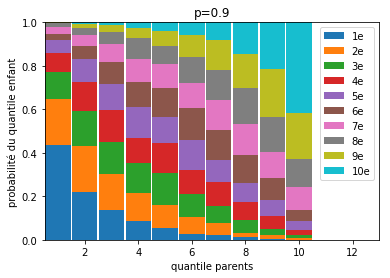

In [67]:
plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10

<div class="panel panel-info">
  <div class="panel-heading"> 
    7
    <a id="m3-step7" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
    Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.
  </div>
</div>

In [68]:
del y_parents, y_child

<div class="panel panel-info">
 <div class="panel-heading"> 
    8
    <a id="m3-step8" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
    Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la Wold Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la Wold Income Distribution.

<br> <br>
   
**Note** : *Les individus ici, sont des informations sur les parents / enfants*
  </div>
</div>

In [69]:
# on considère que chaque centile est un individu enfant : on ne garde que son pays, son quantile et son revenu
dist_inter_gen = dist_revenus[['country', 'quantile', 'income']]
dist_inter_gen.columns = ['country', 'c_i_child', 'income_child']

# on créé 499 copies de chaques enfants
dist_inter_gen = dist_inter_gen.append([dist_inter_gen]*499, ignore_index=True)

# on initialise a 0 les classes parents a 0, elles seront déclarées plus tard
dist_inter_gen['c_i_parent'] = 0

In [70]:
# on change le type des colonnes pour optimiser le stockage
dist_inter_gen['country'] = dist_inter_gen['country'].astype('category')
dist_inter_gen['c_i_child'] = dist_inter_gen['c_i_child'].astype('int8')
dist_inter_gen['c_i_parent'] = dist_inter_gen['c_i_parent'].astype('int8')

<div class="panel panel-info">
  <div class="panel-heading"> 
    9
    <a id="m3-step9" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
    Pour chaque $c_{i,child}$ et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes $ c_{i,parent}$ conformément aux distributions trouvées précédemment. <br>
Par exemple, si $P(c_{i,parent}=8 | c_{i,child}=5,p_j=0.9) = 0.03$ , alors vous assignerez la classe $c_{i,parent} = 8$ à 15 des 500 individus du pays $ j$ ayant $c_{i,child}=5$ , car 500*0.03 = 15.
  </div>
</div>

#### Nous allons, dans un premier temps, générer les distributions conditionnelles des classes de revenues pour chaque pays, en fonction de son *coefficient d'elasticité*

Le calcul des distributions conditionnelles étant long, il est possible de recharger la dernière calculée, qui a été stockée dans le le dossier `variable_cache`

In [72]:
calculer_distributions_conditionnelles = False

In [73]:
# Attention, l'execution de cette cellule peut prendre du temps
# pour une valeur élevée de quantiles :
# pour 100 quantiles ~ 10 minutes d'execution

if calculer_distributions_conditionnelles:
    
    # on calcule les distributions conditionnelles de chaque pays
    
    distributions_conditionnelles = {}
    start_time = time.time()
    for i, row in enumerate(coef_elasticite.iterrows()):
        iso3 = row[0]
        pj = row[1][0]

        clear_output(' ')
        print(f"""{time.time() - start_time:.2f}s - pays {i+1}/{len(coef_elasticite)}
            code iso : {iso3}, pj = {pj:.2f}
            calcul de la distribution conditionnelle...""")

        cd = create_conditional_distributions_matrice(pj, nb_quantiles=100)
        distributions_conditionnelles[iso3] = cd

        print(f"\t-- Calcule fait --")

    # on enregistre en JSON les distributions conditionnelles
    
    with open('variable_cache/distributions_conditionnelles.json', 'w') as fp:
        json.dump(distributions_conditionnelles, fp)
    print("\n-> fichier enregistré au format JSON")

637.75s - pays 116/116
            code iso : TLS, pj = 0.70
            calcul de la distribution conditionnelle...
	-- Calcule fait --

-> fichier enregistré au format JSON


In [140]:
# Ouvre le fichier distribution conditionnelle depuis le dossier variable_cache

with open('variable_cache/distributions_conditionnelles.json', 'r') as fp:
    distributions_conditionnelles = json.load(fp)

##### Exemple

In [75]:
# paramètre
# ----------
pays = 'FRA'
c_i_parent = 13
# sachant..
c_i_child = 85


# affichage
# ---------
pj = coef_elasticite.loc[pays, 'elasticite']
p = distributions_conditionnelles[pays][c_i_child][c_i_parent]

# affichage dynamique de la formule
display(Math(f'P(c_{{i,parent}}={c_i_parent} | c_{{i,child}}={c_i_child},p_{{{pays.lower()}}}={pj:.2f}) = {p}'))

<IPython.core.display.Math object>

----------------

#### Nous allons maintenant génerer, pour chaque couple (`country`,`c_i_child`) (500 individus), la classe des parents. 

D'abord, nous allons optimiser le DataFrame `dist_inter_gen` :

on va rechercher les individus en fonction de leurs `country` et `c_i_child`. <br>
comme il y a beaucoups de lignes (~6 millions), on va mettre en **multi-index** ces deux variable pour optimiser l'indexation (pandas utilise des index lexicaux et des recherches dichotomoques)

In [76]:
dist_inter_gen.set_index(['country', 'c_i_child'], inplace=True)
dist_inter_gen.sort_index(inplace=True)

dist_inter_gen.head(2)

income_child  c_i_parent
country c_i_child                          
ALB     1             728.89795           0
        1             728.89795           0

Nous pouvons ensuite calculer les `c_i_parents` pour chaque couple `(pays, c_i_child)`

Le calcul étant long, il est possible de recharger la dernière calculée, qui a été stocké dans le le dossier `variable_cache`

In [137]:
calculer_c_i_parents = False

In [138]:
# ATTENTION : l'execution de cette cellule prend ~ 2 minute

if calculer_c_i_parents:
    c_i_parents_values = np.arange(1,101, dtype='int8')
    c_i_child_values = np.arange(1,101, dtype='int8')

    start_time = time.time()

    # pour chaque pays..
    for i, code_pays in enumerate(pays_ref['iso3'].values):

        # on recupere le coefficient d'élasticité du pays en cours
        pj = coef_elasticite.loc[code_pays, 'elasticite']

        # affichage de l'avancement..
        clear_output(' ')
        print(f"""{time.time() - start_time:.2f}s - pays {i+1}/{len(pays_ref)}
            code iso : {code_pays}, pj = {pj:.2f}""")

        # pour chaque classe d'enfants c_i_child
        for c_i_child in c_i_child_values:

            # on recupere la distribution des classes parents
            dc = distributions_conditionnelles[code_pays][c_i_child-1]
            # on calcule les valeurs en fonction de cette distribution
            c_i_parents = get_values_from_frequencies(500, c_i_parents_values, frequencies = dc)

            # on l'affecte aux 500 individus du (pays, c_i_child) en cours
            dist_inter_gen.loc[(code_pays, c_i_child), 'c_i_parent'] = c_i_parents
            
    # on enregistre
    dist_inter_gen.to_csv('variable_cache/dist_inter_gen.csv')
    print("\n-> dist_inter_gen enregistré au format CSV")

Une fois que l'ajout des `c_i_parents` a été faite, nous pouvons reconsidérer les colonnes `country` et `c_i_child` comme des variables.

In [139]:
# Ouvre le fichier dist_inter_gen du dossier cache
dist_inter_gen = pd.read_csv('variable_cache/dist_inter_gen.csv')

##### Vérification

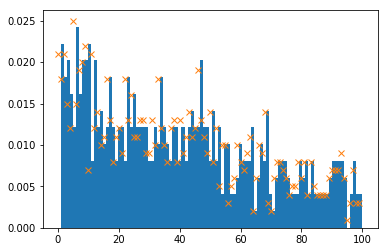

In [83]:
# Pour vérifier, on peut comparer la distribution des individus
# de dist_inter_gen avec la fréquence de distribution_conditionnelle

pays = 'FRA'
c_i_child = 13


a=plt.hist(
    dist_inter_gen.loc[(dist_inter_gen['country'] == pays) & (dist_inter_gen['c_i_child'] == c_i_child), 'c_i_parent'],
    density=True, bins=100
)
plt.plot(distributions_conditionnelles[pays][c_i_child-1], 'x')

<div class="panel panel-info">
  <div class="panel-heading"> 
    10
    <a id="m3-step10" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
    Éventuellement et pour éviter toute confusion, effacez la variable $c_{i,child}$  : nous n'en avons pas besoin pour la mission 4.
  </div>
</div>

In [84]:
dist_inter_gen.drop('c_i_child', axis=1, inplace=True)

<div class="panel panel-info">
  <div class="panel-heading"> 
    11
    <a id="m3-step11" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
    Assurez-vous que votre nouvel échantillon contiennent bien les variables initialement présentes dans la World income distribution : $ m_j $ et $ G_j $  .
  <br> <br>
  **NOTE** : $m_j$ est le salaire moyen et $G_j$ est l'indice de Gini
  </div>
</div>

In [85]:
dist_inter_gen = dist_inter_gen.merge(gdp_ppp, how='left', left_on='country', right_index=True)
dist_inter_gen = dist_inter_gen.merge(indice_gini_ref, how='left', left_on='country', right_index=True)

In [87]:
dist_inter_gen.sample(2)

,country,income_child,c_i_parent,gdpppp,gini_ref
3871898,NER,438.87103,74,631.0,37.516667
926727,CIV,312.89670,50,1526.0,40.833333


In [88]:
dist_inter_gen.shape

(5800000, 5)

## Mission 4 <a id="mission-4" href="#sommaire" class="btn-sm btn-default" >retour au sommaire</a>

Pour cette mission 4, nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc.

### ANOVA

<div class="panel panel-info">
  <div class="panel-heading"> 
    ANOVA
    <a id="m4-anova" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
    Appliquez une ANOVA sur vos données, en n’incluant comme variable explicative que le pays de l’individu. Analysez la performance du modèle.
  </div>
</div>

Text(0,0.5,'revenu moyen des enfants')

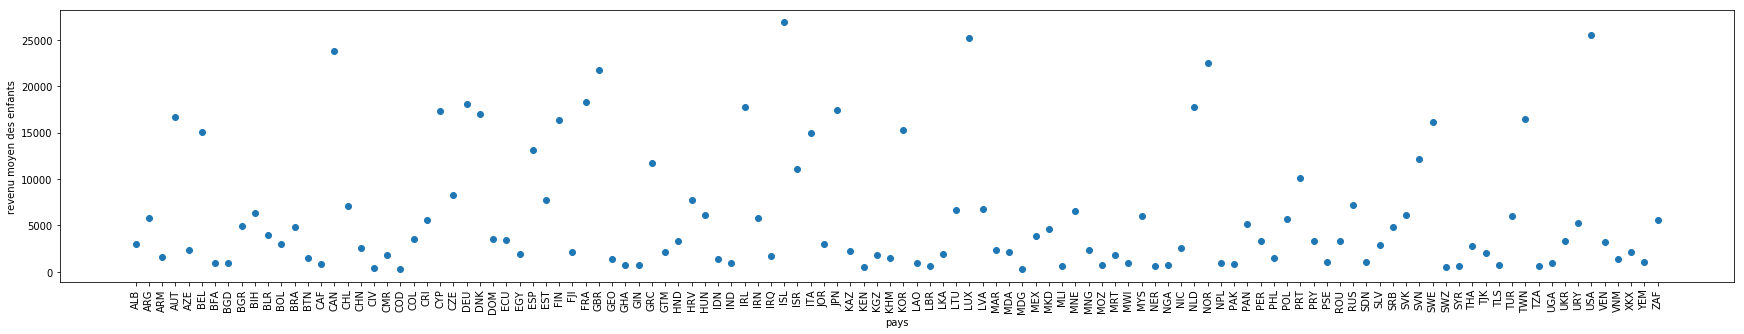

In [90]:
plt.figure(figsize=(30,5))
rs = plt.plot(dist_inter_gen.groupby('country').income_child.mean(), 'o')
rs = plt.xticks(rotation=90)
plt.xlabel('pays')
plt.ylabel('revenu moyen des enfants')

On constate bien une variation de la moyenne des revenus par pays. 

**On va la quantifier avec une ANOVA**

-----------------

Il y a 50 000 individus par pays, on ne va en garder que certains, au hasard, pour avoir un temps de calcul du modèle raisonnable.

In [91]:
nb_ind_pays = 5000
dist_inter_gen_sample = (dist_inter_gen.groupby('country')
                            .apply(lambda pop_pays: pop_pays.sample(nb_ind_pays))
                            .reset_index(drop=True))

Calcul du modèle

In [92]:
%%time

# calcul du modèle
anova_mod = ols('income_child ~ country', data=dist_inter_gen_sample).fit()

# accès aux données qui nous intéressent

anova_res = sm.stats.anova_lm(anova_mod, typ=2)

fvaleur = anova_res['F'][0]
pvaleur = anova_res['PR(>F)'][0]
esq_sm = anova_res['sum_sq'][0]/(anova_res['sum_sq'][0]+anova_res['sum_sq'][1])

CPU times: user 12.9 s, sys: 1.13 s, total: 14.1 s
Wall time: 9 s


In [93]:
display(Markdown(f"""
Notre modèle d'ANOVA est basé uniquement sur la variable qualitative `pays`. 

Il a *comme rapport de corrélation* $\eta^2 = {esq_sm:.2f}$. <br>
$\Rightarrow$ *ici, la $f$-valeur = {fvaleur:.2f} et la $p$-valeur = {pvaleur}. Il y a donc très peu de chance que cette valeur d'$\eta^2$ soit liée au hasard.* 

On peut donc conclure que, dans le monde, **la variation de revenue** entre les personnes est expliquée à **{esq_sm*100:.0f}% par leurs pays d'origine**.
"""))


Notre modèle d'ANOVA est basé uniquement sur la variable qualitative `pays`. 

Il a *comme rapport de corrélation* $\eta^2 = 0.50$. <br>
$\Rightarrow$ *ici, la $f$-valeur = 5054.66 et la $p$-valeur = 0.0. Il y a donc très peu de chance que cette valeur d'$\eta^2$ soit liée au hasard.* 

On peut donc conclure que, dans le monde, **la variation de revenue** entre les personnes est expliquée à **50% par leurs pays d'origine**.


### Régressions linéaires <a id="m4-reg_lin" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

Nous allons construire des régressions linéaire pour expliquer la variable `income_child`

<div class="panel panel-info">
  <div class="panel-heading"> 
    Régression linéaire 1
    <a id="reg1" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
   Appliquez une régression linéaire sur vos données, en n’incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?
  </div>
</div>

In [94]:
# définition des variables
reg1_X = dist_inter_gen[['gdpppp', 'gini_ref']]
reg1_X = sm.add_constant(reg1_X)
reg1_y = dist_inter_gen['income_child']

#### Version sans logarithme <a id="reg1-lin" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

In [95]:
# calcul du modèle
reg1_lin_mod = sm.OLS(reg1_y, reg1_X)
reg1_lin_res = reg1_lin_mod.fit()

##### Analyse des résidus

[source](https://zhiyzuo.github.io/Linear-Regression-Diagnostic-in-Python/)

In [96]:
# on fait un df contenant les résidus pour chaque valeur prédites
reg1_lin_residual = (pd.concat([
                reg1_lin_res.resid,
                reg1_lin_res.fittedvalues
            ], axis=1)
     .drop_duplicates())

reg1_lin_residual.columns = ['residual', 'val_pred']

###### Normalité de leur distribution

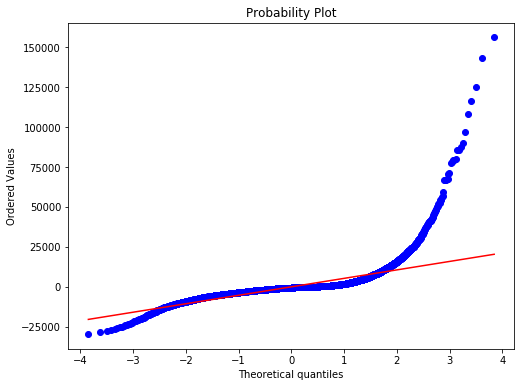

In [97]:
# on affiche le Q-Q plot
fig, ax = plt.subplots(figsize=(8,6))
_ = st.probplot(reg1_lin_residual['residual'], plot=ax, fit=True)

###### Égalité de leur variance

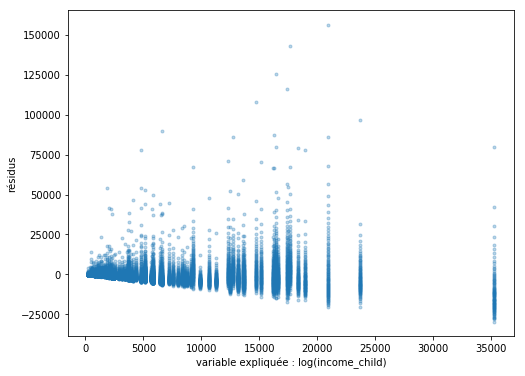

In [98]:
# on va afficher le nuage de la variance résiduelle
fig = plt.figure(figsize=(8,6))
plt.plot(reg1_lin_residual['val_pred'], reg1_lin_residual['residual'], '.', alpha=0.3)
plt.xlabel('variable expliquée : log(income_child)')
_ = plt.ylabel('résidus')

Les résidus **ne suivent pas une loi normale** et on voit que **la variance des résidus n'est pas constante**.

La relation n'est pas linéaire, **la régression linéaire n'est donc pas un modèle viable**.

Etant donné que les variables de** revenus ont une tendance exponentiel** (selon les courbes de Lorenz), on va les mettre au **logarithme avant**.

#### Version avec logarithme <a id="reg1-log" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

In [99]:
# mise en logarithme du GDP PPP et de income child

# variable explicative
reg1_log_X = reg1_X.copy()
reg1_log_X['gdpppp'] = np.log(reg1_log_X['gdpppp'])

# variable expliquee
reg1_log_y = reg1_y.copy()
reg1_log_y = np.log(reg1_log_y)

In [100]:
# calcul du modèle
reg1_log_mod = sm.OLS(reg1_log_y, reg1_log_X)
reg1_log_res = reg1_log_mod.fit()

##### Test de significativité globale 

On va faire un test de type **F-ratio**

In [101]:
reg1_log_fval = reg1_log_res.fvalue
reg1_log_f_pval = reg1_log_res.f_pvalue

In [102]:
display(Markdown(
f"""
la statistique de test **F vaut {reg1_log_fval:.0f}** (*p-valeur = {reg1_log_f_pval:.2f}*)
"""))


la statistique de test **F vaut 5473316** (*p-valeur = 0.00*)


On peut donc **rejeter $H_0$**, et affirmer que **les coefficients sont significativement non-nuls**.

##### Analyse des résidus

In [103]:
# on fait un df contenant les résidus pour chaque valeur prédites
reg1_log_residual = (pd.concat([
                reg1_log_res.resid,
                reg1_log_res.fittedvalues
            ], axis=1)
     .drop_duplicates())

reg1_log_residual.columns = ['residual', 'val_pred']

**Normalité de leur distribution**

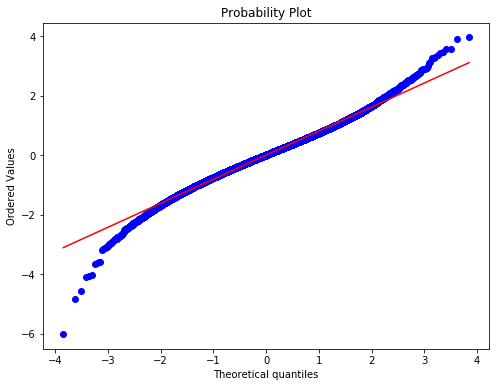

In [104]:
fig, ax = plt.subplots(figsize=(8,6))
_ = st.probplot(reg1_log_residual['residual'], plot=ax, fit=True)

**Égalité de leur variance**

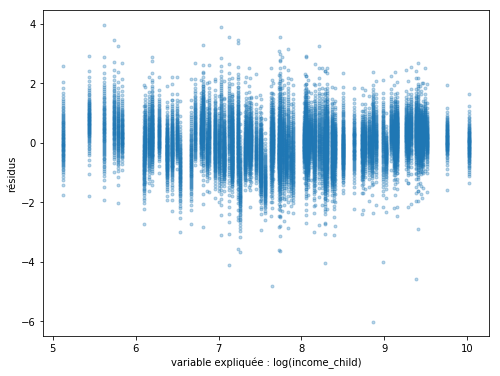

In [105]:
# on va afficher le nuage de la variance résiduelle
fig = plt.figure(figsize=(8,6))
plt.plot(reg1_log_residual['val_pred'], reg1_log_residual['residual'], '.', alpha=0.3)
plt.xlabel('variable expliquée : log(income_child)')
_ = plt.ylabel('résidus')

Ici, on voit que **les résidus semblent suivre une loi normale** et que leur **variance est constante**.

**La mise au logarithme a donc bien donnée une tendance linéaire aux données**.

**Indépendance linéaire**

[Variance Inflation Factor](https://etav.github.io/python/vif_factor_python.html)

In [106]:
reg1_log_vif = pd.DataFrame()
reg1_log_vif["VIF Factor"] = [variance_inflation_factor(reg1_log_X.values, i) for i in range(reg1_log_X.shape[1])]
reg1_log_vif["features"] = reg1_log_X.columns

In [107]:
reg1_log_vif

,VIF Factor,features
0,105.806752,const
1,1.117731,gdpppp
2,1.117731,gini_ref


Ici, le **VIF** de nos variables est faible (**<10**). On peut donc considérer qu'**il n'y a pas de problème de colinéarité**.

##### Individus hors normes

[distance de Cooks](http://mpastell.com/2013/04/19/python_regression/)

In [108]:
reg1_log_cooks_dist,_  = reg1_log_res.get_influence().cooks_distance

In [109]:
# calcul du seuil, usuellement considéré a 4 / (n-p)
n, p = reg1_log_X.shape
reg1_log_cooks_seuil = 4 / (n-p)
# on compte le nombre d'outliers
reg1_log_nb_outlier = np.sum(reg1_log_cooks_dist > reg1_log_cooks_seuil)

In [110]:
display(Markdown(
f"""
On considère que les individus ayant une **distance de Cooks > à {reg1_log_cooks_seuil:.1e}** sont des outliers influents.

On en compte **{reg1_log_nb_outlier}**, soit **{reg1_log_nb_outlier / n * 100:.1f}%**.
"""))


On considère que les individus ayant une **distance de Cooks > à 6.9e-07** sont des outliers influents.

On en compte **336500**, soit **5.8%**.


<div class="panel panel-info">
  <div class="panel-heading"> 
    Question
    <a id="reg1_q1" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
   Selon ce modèle, donnez la décomposition de variance totale expliquée par :
<ul>
    <li> Le pays de naissance (ie. le revenu moyen et l’indice de Gini) </li>
    <li> Les autres facteurs non considérés dans le modèle (efforts, chance, etc.) </li>
</ul>
  </div>
</div>

In [111]:
reg1_log_sct = reg1_log_res.centered_tss
reg1_log_sce = reg1_log_res.ess
reg1_log_scr = reg1_log_res.ssr
reg1_log_r2 = reg1_log_res.rsquared

In [112]:
display(Markdown(f"""
La décomposition de la variance de notre modèle est : <br>

**SCT = SCE + SCR**
- SCT = {reg1_log_sct:.0f} <br>
- SCE = {reg1_log_sce:.0f} <br>
- SCR = {reg1_log_scr:.0f} <br>

Ce qui donne une valeur $R^2 = {reg1_log_r2:.2f}$

Notre modèle explique donc **{reg1_log_r2*100:.0f}% de la variance totale**.
"""))


La décomposition de la variance de notre modèle est : <br>

**SCT = SCE + SCR**
- SCT = 11062517 <br>
- SCE = 7231145 <br>
- SCR = 3831372 <br>

Ce qui donne une valeur $R^2 = 0.65$

Notre modèle explique donc **65% de la variance totale**.


<hr style='height:1px'>

<div class="panel panel-info">
  <div class="panel-heading"> 
   Régression linéaire 2
   <a id="reg2" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
   Améliorez le modèle précédent en incluant maintenant la classe de revenu des parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?
  </div>
</div>

In [113]:
# définition des variables
reg2_X = dist_inter_gen[['gdpppp', 'gini_ref', 'c_i_parent']]
reg2_X = sm.add_constant(reg2_X)
reg2_y = dist_inter_gen['income_child']

#### Version sans logarithme <a id="reg2-lin" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

In [114]:
# calcul du modèle
reg2_lin_mod = sm.OLS(reg2_y, reg2_X)
reg2_lin_res = reg2_lin_mod.fit()

##### Analyse des résidus

In [115]:
# on fait un df contenant les résidus pour chaque valeur prédites
reg2_lin_residual = (pd.concat([
                reg2_lin_res.resid,
                reg2_lin_res.fittedvalues
            ], axis=1)
     .drop_duplicates()
     .sample(5000))

reg2_lin_residual.columns = ['residual', 'val_pred']

###### Normalité de leur distribution

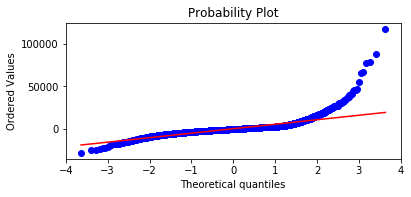

In [116]:
# on affiche le Q-Q plot
fig, ax = plt.subplots(figsize=(6,2.5))
_ = st.probplot(reg2_lin_residual['residual'], plot=ax, fit=True)

###### Égalité de leur variance

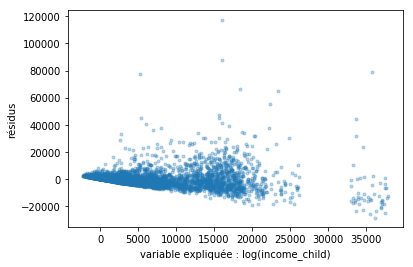

In [117]:
# on va afficher le nuage de la variance résiduelle
plt.plot(reg2_lin_residual['val_pred'], reg2_lin_residual['residual'], '.', alpha=0.3)
plt.xlabel('variable expliquée : log(income_child)')
_ = plt.ylabel('résidus')

En observant les résidus, on constate encore qu'il faut mettre au **logarithme**

#### Version avec logarithme <a id="reg2-log" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

In [118]:
# mise en logarithme du GDP PPP et de income child

# variables explicatives
reg2_log_X = reg2_X.copy()
reg2_log_X['gdpppp'] = np.log(reg2_log_X['gdpppp'])
reg2_log_X['c_i_parent'] = np.log(reg2_log_X['c_i_parent'])

# variable explilquee
reg2_log_y = reg2_y.copy()
reg2_log_y = np.log(reg2_log_y)

In [119]:
# calcul du modèle
reg2_log_mod = sm.OLS(reg2_log_y, reg2_log_X)
reg2_log_res = reg2_log_mod.fit()

##### Test de significativité globale 

On va faire un test de type **F-ratio**

In [120]:
reg2_log_fval = reg2_log_res.fvalue
reg2_log_f_pval = reg2_log_res.f_pvalue

In [121]:
display(Markdown(
f"""
la statistique de test **F vaut {reg2_log_fval:.0f}** (*p-valeur = {reg2_log_f_pval:.2f}*)
"""))


la statistique de test **F vaut 4510451** (*p-valeur = 0.00*)


On peut donc **rejeter $H_0$**, et affirmer que **les coefficients sont significativement non-nuls**.

##### Analyse des résidus

In [122]:
# on fait un df contenant les résidus pour chaque valeur prédites
reg2_log_residual = (pd.concat([
                reg2_log_res.resid,
                reg2_log_res.fittedvalues
            ], axis=1)
     .drop_duplicates()
     .sample(5000))

reg2_log_residual.columns = ['residual', 'val_pred']

**Normalité de leur distribution**

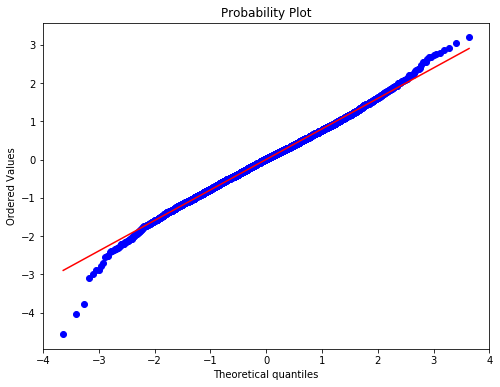

In [123]:
fig, ax = plt.subplots(figsize=(8,6))
_ = st.probplot(reg2_log_residual['residual'], plot=ax, fit=True)

**Égalité de leur variance**

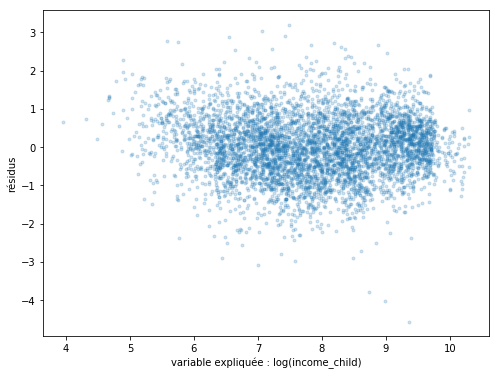

In [124]:
# on va afficher le nuage de la variance résiduelle
plt.figure(figsize=(8,6))
plt.plot(reg2_log_residual['val_pred'], reg2_log_residual['residual'], '.', alpha=0.2)
plt.xlabel('variable expliquée : log(income_child)')
_ = plt.ylabel('résidus')

**Les résidus semblent suivre une loi normale** et leur **variance semble constante**.

**La mise au logarithme a donnc donnée une régression linéaire viable**.

**Indépendance linéaire**

In [125]:
reg2_log_vif = pd.DataFrame()
reg2_log_vif["VIF Factor"] = [variance_inflation_factor(reg2_log_X.values, i) for i in range(reg2_log_X.shape[1])]
reg2_log_vif["features"] = reg2_log_X.columns

In [126]:
reg2_log_vif

,VIF Factor,features
0,121.269487,const
1,1.117731,gdpppp
2,1.117731,gini_ref
3,1.000001,c_i_parent


Ici, le **VIF** de nos variables est faible (**<10**). On peut donc considérer qu'**il n'y a pas de problème de colinéarité**.

##### Individus hors normes

In [127]:
# on récupere les distances de Cooks
reg2_log_cooks_dist,_  = reg2_log_res.get_influence().cooks_distance

# calcul du seuil, usuellement considéré a 4 / (n-p)
n, p = reg2_log_X.shape
reg2_log_cooks_seuil = 4 / (n-p)

# on compte le nombre d'outliers
reg2_log_nb_outlier = np.sum(reg2_log_cooks_dist > reg2_log_cooks_seuil)

In [128]:
display(Markdown(
f"""
On considère que les individus ayant une **distance de Cooks > à {reg2_log_cooks_seuil:.1e}** sont des outliers influents.

On en compte **{reg2_log_nb_outlier}**, soit **{reg2_log_nb_outlier / n * 100:.1f}%**.
"""))


On considère que les individus ayant une **distance de Cooks > à 6.9e-07** sont des outliers influents.

On en compte **344336**, soit **5.9%**.


<div class="panel panel-info">
  <div class="panel-heading"> 
    Question
    <a id="reg2_q1" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
   En observant le coefficient de régression associé à l’indice de Gini, peut-on affirmer que le fait de vivre dans un pays plus inégalitaire favorise plus de personnes qu’il n’en défavorise ?
  </div>
</div>

In [129]:
coef_reg_gini = reg2_log_res.params['gini_ref']
display(Markdown(f"""
Le coefficient de régression associé à l'indice de Gini vaut **{coef_reg_gini:.3f}**.

Cela signifie que, **pour GDP PPP et c_i_parents constants** : <br>
Lorsque le Gini **augmente de 1**, le *log du revenu* diminue de **{-coef_reg_gini:.3f}** <br>
et *le revenu* est  divisé par $e^{{{-coef_reg_gini:.3f}}}$  = **{np.exp(-coef_reg_gini):.4f}**.

On peut généraliser pour un pas de *n* : <br>
le log du revenu diminuera de **{-coef_reg_gini:.3f} x n** <br>
et le revenu sera divisé par $e^{{{-coef_reg_gini:.3f}.n}} = {{{np.exp(-coef_reg_gini):.4f}}}^n$

"""))


Le coefficient de régression associé à l'indice de Gini vaut **-0.018**.

Cela signifie que, **pour GDP PPP et c_i_parents constants** : <br>
Lorsque le Gini **augmente de 1**, le *log du revenu* diminue de **0.018** <br>
et *le revenu* est  divisé par $e^{0.018}$  = **1.0178**.

On peut généraliser pour un pas de *n* : <br>
le log du revenu diminuera de **0.018 x n** <br>
et le revenu sera divisé par $e^{0.018.n} = {1.0178}^n$



On constate que, pour un **GDP PPP et une classe revenu parent constante**, **la variation de l'indice de Gini a un impact non négligeable sur le revenu final**.

Imaginons le cas extrême : <br> 
Pour **2 individus** ayant la **même classe parent**, et venant d'un pays avec **le meme GDP PPP** mais avec un indice de **Gini opposé**, l'un étant de **0**, et l'autre de **100**.

Alors, notre modèle prédit que **le second indivdu gagnera 5.9 fois moins que le premier**.

In [130]:
# vérificaiton empirque : on va générer deux revenus pour des ginis différents, a tout autre valeurs constantes

# définition des gini
gini_a = 0
gini_b = 100

# constantes
log_gdpppp_c = 7
log_c_i_parent_c = 2

# prédiction des log des revenus avec notre modèle
log_y_a = reg2_log_res.predict([1.0, log_gdpppp_c, gini_a, log_c_i_parent_c])[0]
log_y_b = reg2_log_res.predict([1.0, log_gdpppp_c, gini_b, log_c_i_parent_c])[0]
# log revenu --> revenu
y_a, y_b = np.exp(log_y_a), np.exp(log_y_b)

# affichage
display(Markdown(
f"""
$y_{{gini={gini_a}}} = {y_a:.0f}$ <br>
$y_{{gini={gini_b}}} = {y_b:.0f}$ <br>

$ y_{{gini={gini_a}}} / y_{{gini={gini_b}}} = {{{y_a/y_b:.4f}}}$
"""))


$y_{gini=0} = 632$ <br>
$y_{gini=100} = 108$ <br>

$ y_{gini=0} / y_{gini=100} = {5.8598}$


<div class="panel panel-info">
  <div class="panel-heading"> 
    Question
     <a id="reg2_q2" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>
  </div>
  <div class="panel-body">
  Selon ce dernier modèle, donnez la décomposition de variance totale expliquée par :
<ul>
    <li> Le pays de naissance et le revenu des parents </li>
    <li> Les autres facteurs non considérés dans le modèle (efforts, chance, etc.) </li>
</ul>
  </div>
</div>

In [131]:
reg2_log_sct = reg2_log_res.centered_tss
reg2_log_sce = reg2_log_res.ess
reg2_log_scr = reg2_log_res.ssr
reg2_log_r2 = reg2_log_res.rsquared

In [132]:
display(Markdown(f"""
La décomposition de la variance de notre modèle est : <br>

**SCT = SCE + SCR**
- SCT = {reg2_log_sct:.0f} <br>
- SCE = {reg2_log_sce:.0f} <br>
- SCR = {reg2_log_scr:.0f} <br>

Ce qui donne une valeur $R^2 = {reg2_log_r2:.2f}$

Notre modèle explique donc **{reg2_log_r2*100:.0f}% de la variance totale**.
"""))


La décomposition de la variance de notre modèle est : <br>

**SCT = SCE + SCR**
- SCT = 11062517 <br>
- SCE = 7743423 <br>
- SCR = 3319094 <br>

Ce qui donne une valeur $R^2 = 0.70$

Notre modèle explique donc **70% de la variance totale**.


----------------
## Prédiction finale <a id="prediction-finale" style="margin-left:20px" href="#sommaire" class="btn-sm btn-default" > sommaire </a>

Nous allons faire une prédiction

In [134]:
# carateristiques de l'individus :
c_i_parent_ind = 77
pays = 'FRA'
# recuperation des variables liées au pays
gdpppp_ind = gdp_ppp.loc[pays][0]
indice_gini_ind = indice_gini_ref.loc[pays][0]

# mise au logarithme
log_gdpppp_ind = np.log(gdpppp_ind)
log_indice_gini_ind = np.log(indice_gini_ind)
log_c_i_parent_ind = np.log(c_i_parent_ind)

# prédiction avec notre modèle
income_child = np.exp(reg2_log_res.predict([1.0, log_gdpppp_ind, log_indice_gini_ind, log_c_i_parent_ind])[0])

# on va aussi afficher le revenu moyen de la classe parent..
c_i_parent_ind_income = dist_revenus.loc[(dist_revenus['country'] == pays) & (dist_revenus['quantile'] == 77), 'income'].values[0]

display(Markdown(
f"""
Soit un parent de classe de revenu **{c_i_parent_ind}** *(en moyenne {c_i_parent_ind_income})* et d'un pays dont
- le pouvoir d'achat GDP PPP = **{gdpppp_ind}**
- l'indice de Gini vaut **{indice_gini_ind:.2f}**

Alors notre modèle prédit que l'enfant gagnera **{income_child:.2f}**
"""))


Soit un parent de classe de revenu **77** *(en moyenne 22165.895)* et d'un pays dont
- le pouvoir d'achat GDP PPP = **30357.0**
- l'indice de Gini vaut **32.09**

Alors notre modèle prédit que l'enfant gagnera **21864.49**
